<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/bag_of_Words_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np
import cv2

import matplotlib.pyplot as plt

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [4]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'/content/drive/MyDrive/cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        x_train.append(img)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:02<00:00, 85.22it/s] 


(750, 512, 512)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [7]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

2


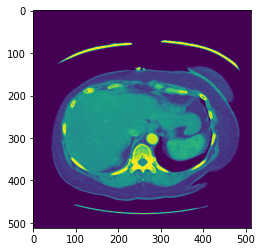

In [8]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

# Descriptors extraction:

In [9]:
# Create List where all the descriptors will be stored
des_list = []

# Creating an object to apply key point extraction
brisk = cv2.xfeatures2d.SIFT_create() #cv2.create_SURF(30)

In [ ]:
#!pip install opencv-contrib-python==4.4.* opencv-python==4.4.*

In [10]:
# loop over the all the images and find the descriptions
for im in shufled_X_train:
    #function to get kpts and des
    kpts, des = brisk.detectAndCompute(im, None) 
    des_list.append(des) 

In [14]:
# let's analyze the words / descriptors 
lens_desc = [len(desc) for desc in des_list]

print('Total descriptors :', sum(lens_desc))
print('Unique descriptors :', sum(list(set(lens_desc))))
print('Shared descriptors :', sum(lens_desc)-sum(list(set(lens_desc))))
# max number of des found in a single image
print('Max descriptors: ', max(lens_desc)) 
# min number of des found in a single image
print('Min descriptors: ', min(lens_desc)) 
# avg number of des found in a single image
print('Mean descriptors: ', round(sum(lens_desc) / len(des_list)))

Total descriptors : 708628
Unique descriptors : 482204
Shared descriptors : 226424
Max descriptors:  1649
Min descriptors:  347
Mean descriptors:  945


# Vectorizing the featues:

In [15]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for descriptor in tqdm(des_list[1:]):
    descriptors = np.vstack((descriptors, descriptor))  

# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  
descriptors_float.shape

100%|██████████| 749/749 [00:41<00:00, 18.27it/s]


(708246, 128)

# Applying K-means and Tf-idf:

## Apply k-means and make histograms for images:

In [21]:
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 300
voc, variance = kmeans(descriptors_float, k, 1) 

In [22]:
# Calculate the histogram of features and represent them as vector
# vq Assigns codes from a code book to observations.

im_features = np.zeros((len(X_train), k), "float32")
# loop over all the images
for i in tqdm(range(len(X_train))):
    # extract all the words and distances from vector quantization of k-means
    words, distance = vq(des_list[i], voc)
    for w in words:
        im_features[i][w] += 1

100%|██████████| 750/750 [00:08<00:00, 90.69it/s]


In [23]:
im_features.shape

(750, 300)

## Apply Tf-idf:

In [24]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
# get the inverse document frequency
idf = np.array(np.log((1.0 * len(X_train) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

In [25]:
from sklearn.preprocessing import StandardScaler

# Scaling the words
# Standardize features by removing the mean and scaling to unit variance
# In a way normalization
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
im_features.shape

(750, 300)

# Splitting training and test: 

In [26]:
# NUM_TRAIN = int(NUM * CLASSES * 0.85)

# x_train = im_features[ : NUM_TRAIN]
# y_train = shufled_Y_train[ : NUM_TRAIN] 

# x_test = im_features[NUM_TRAIN : ]
# y_test = shufled_Y_train[NUM_TRAIN:] 

# x_train.shape

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(im_features, shufled_Y_train,
                                                    stratify=shufled_Y_train, 
                                                    test_size=0.2)
results = {}

# Applying Models:

## SVM:

In [28]:
# Train the Linear SVM
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=10000)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['SVM'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [29]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[49  1  0]
 [ 0 50  0]
 [ 1  0 49]]


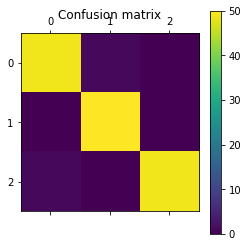

In [30]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)


## Random Forest:

In [31]:
# creating a random forest
clf =  RandomForestClassifier(n_estimators = 100, random_state=30)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


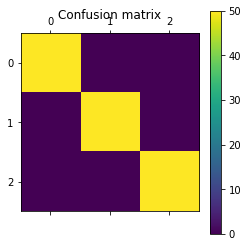

In [32]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)


## Decision Tree:

In [33]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9266666666666666

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        50
           1       0.94      0.88      0.91        50
           2       0.92      0.96      0.94        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



[[47  2  1]
 [ 3 44  3]
 [ 1  1 48]]


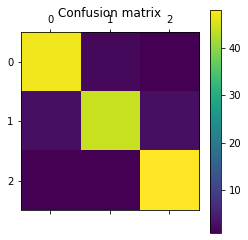

In [34]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

[Text(0.45714285714285713, 0.9444444444444444, 'X[9] <= -0.786\ngini = 0.667\nsamples = 600\nvalue = [200, 200, 200]'),
 Text(0.2571428571428571, 0.8333333333333334, 'X[133] <= 2.432\ngini = 0.192\nsamples = 182\nvalue = [163, 7, 12]'),
 Text(0.2, 0.7222222222222222, 'X[6] <= 2.207\ngini = 0.09\nsamples = 170\nvalue = [162, 7, 1]'),
 Text(0.17142857142857143, 0.6111111111111112, 'X[284] <= 1.272\ngini = 0.069\nsamples = 168\nvalue = [162, 5, 1]'),
 Text(0.11428571428571428, 0.5, 'X[48] <= 0.884\ngini = 0.036\nsamples = 164\nvalue = [161, 3, 0]'),
 Text(0.08571428571428572, 0.3888888888888889, 'X[63] <= 6.178\ngini = 0.024\nsamples = 163\nvalue = [161, 2, 0]'),
 Text(0.05714285714285714, 0.2777777777777778, 'X[210] <= 1.829\ngini = 0.012\nsamples = 162\nvalue = [161, 1, 0]'),
 Text(0.02857142857142857, 0.16666666666666666, 'gini = 0.0\nsamples = 160\nvalue = [160, 0, 0]'),
 Text(0.08571428571428572, 0.16666666666666666, 'X[165] <= 0.462\ngini = 0.5\nsamples = 2\nvalue = [1, 1, 0]'),
 Te

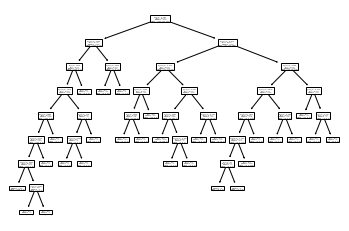

In [35]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## AdaBoost Classifier:

In [36]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['ada_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.92

              precision    recall  f1-score   support

           0       0.98      0.86      0.91        50
           1       0.89      0.94      0.91        50
           2       0.91      0.96      0.93        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



[[43  4  3]
 [ 1 47  2]
 [ 0  2 48]]


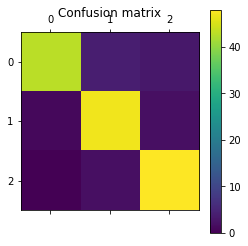

In [37]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## XG Boost Classifier:

In [38]:
# Create XG boost classifer object
clf = XGBClassifier()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['xg_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


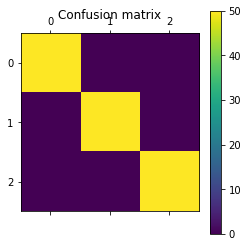

In [39]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Gaussian Naive Bayes:

In [40]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['gauss_NB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       0.96      0.98      0.97        50
           2       0.96      0.98      0.97        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



[[48  1  1]
 [ 0 49  1]
 [ 0  1 49]]


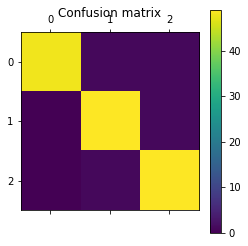

In [41]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Logistic Regression:

In [42]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['log_regression'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# Plotting the results:

<BarContainer object of 7 artists>

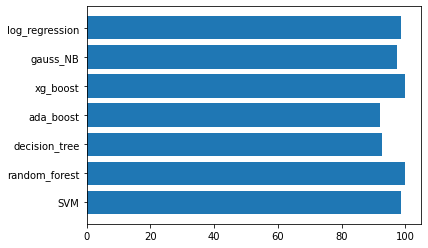

In [43]:
plt.barh(list(results.keys()), results.values())

In [44]:
results

{'SVM': 98.67,
 'ada_boost': 92.0,
 'decision_tree': 92.67,
 'gauss_NB': 97.33,
 'log_regression': 98.67,
 'random_forest': 100.0,
 'xg_boost': 100.0}